# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [ ]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
    !mkdir tables

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate, savefig

## The binomial distribution

Suppose I tell you that a coin is "fair", that is, the probability of heads is 50%.  If you spin it twice, there are four outcomes: `HH`, `HT`, `TH`, and `TT`.  All four outcomes have the same probability, 25%.  

If we add up the total number of heads, there are three possible outcomes: 0, 1, or 2.  The probability of 0 and 2 is 25%, and the probability of 1 is 50%.

More generally, suppose the probability of heads is `p` and we spin the coin `n` times.  What is the probability that we get a total of `k` heads?

The answer is given by the binomial distribution:

$P(k; n, p) = \binom{n}{k} p^k (1-p)^{n-k}$

where $\binom{n}{k}$ is the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient), usually pronounced "n choose k".

We can compute this expression ourselves, but we can also use the SciPy function `binom.pmf`:

In [3]:
from scipy.stats import binom

n = 2
p = 0.5
ks = np.arange(n+1)

a = binom.pmf(ks, n, p)
a

array([0.25, 0.5 , 0.25])

If we put this result in a `Pmf`, the result is the distribution of `k` for the given values of `n` and `p`.

In [4]:
pmf_k = Pmf(a, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


In [5]:
from utils import write_pmf
write_pmf(pmf_k, 'table03-01')

The following function computes the binomial distribution for given values of `n` and `p`:

In [6]:
def make_binomial(n, p):
    """Make a binomial PMF.
    
    n: number of spins
    p: probability of heads
    
    returns: Pmf representing the distribution
    """
    ks = np.arange(n+1)
    a = binom.pmf(ks, n, p)
    return Pmf(a, ks)

And here's what it looks like with `n=250` and `p=0.5`:

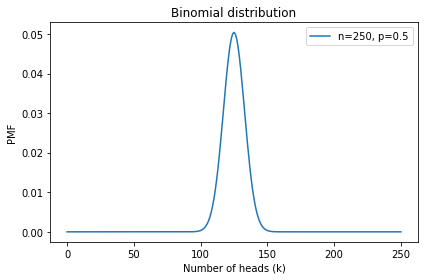

In [7]:
pmf_k = make_binomial(n=250, p=0.5)
pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

savefig('fig03-01')

The most likely value in this distribution is 125:

In [8]:
pmf_k.max_prob()

125

But even though it is the most likely value, the probability that we get exactly 125 heads is only about 5%.

In [9]:
pmf_k[125]

0.05041221314731537

In MacKay's example, we got 140 heads, which is less likely than 125:

In [10]:
pmf_k[140]

0.008357181724917673

In the article MacKay quotes, the statistician says, ‘If the coin were unbiased the chance of getting a result as extreme as that would be less than 7%’.

We can use the binomial distribution to check his math.  The following function takes a PMF and computes the total probability of values greater than or equal to `threshold`. 

In [11]:
def ge_dist(pmf, threshold):
    """Probability of values greater than a threshold.
    
    pmf: Series representing a PMF
    threshold: value to compare to
    
    returns: probability
    """
    ge = (pmf.index >= threshold)
    total = pmf[ge].sum()
    return total

Here's the probability of getting 140 heads or more:

In [12]:
ge_dist(pmf_k, 140)

0.033210575620022706

`Pmf` provides a method that does the same computation.

In [13]:
pmf_k.ge_dist(140)

0.033210575620022706

The result is about 3.3%, which is less than 7%.  The reason is that the statistician includes all values "as extreme as" 140, which includes values less than or equal to 110, because 140 exceeds the expected value by 15 and 110 falls short by 15.

In [14]:
pmf_k.le_dist(110)

0.033210575620022706

The probability of values less than or equal to 110 is also 3.3%,
so the total probability of values "as extreme" as 140 is 6.6%.

The point of this calculation is that these extreme values are unlikely if the coin is fair.

That's interesting, but it doesn't answer MacKay's question.  Let's see if we can.

## The Euro problem


We can make a uniform prior and update it with 140 heads and 110 tails:

In [15]:
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

I'll use a dictionary to store the likelihoods for `H` and `T`:

In [16]:
likelihood = {
    'H': hypos,
    'T': 1 - hypos
}

I'll use a list of strings to represent the dataset:


In [17]:
dataset = 'H' * 140 + 'T' * 110

The following function does the update.

In [18]:
def update_euro(pmf, dataset):
    """Updates the Suite with the given number of heads and tails.

    pmf: Pmf representing the prior
    data: tuple of heads and tails
    """
    for data in dataset:
        pmf *= likelihood[data]

    pmf.normalize()

We can do multiple updates by looping through the data:

In [19]:
posterior = prior.copy()
update_euro(posterior, dataset)

And here's what the posterior looks like.

In [20]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

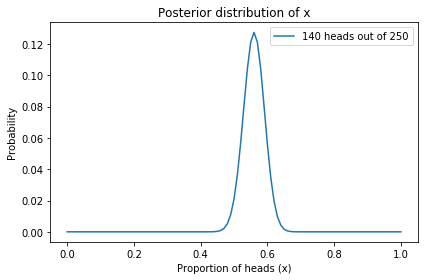

In [21]:
posterior.plot(label='140 heads out of 250')
decorate_euro(title='Posterior distribution of x')
savefig('fig03-02')

The peak of the posterior is at 56%, which is the proportion of heads in the dataset.

In [22]:
posterior.max_prob()

0.56

## Different priors

Let's see how that looks with different priors.

In [23]:
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

101

And another that makes a triangular prior.

In [24]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, hypos, name='triangle')
triangle.normalize()

2500

Here's what they look like:

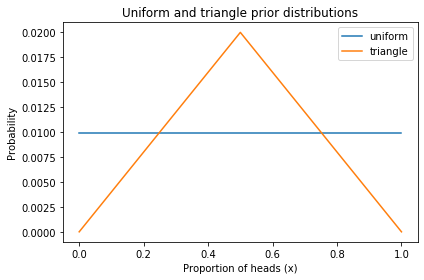

In [25]:
uniform.plot()
triangle.plot()
decorate_euro(title='Uniform and triangle prior distributions')

savefig('fig03-03')

If we update them both with the same data:

In [26]:
update_euro(uniform, dataset)
update_euro(triangle, dataset)

The results are almost identical; the remaining difference is unlikely to matter in practice.

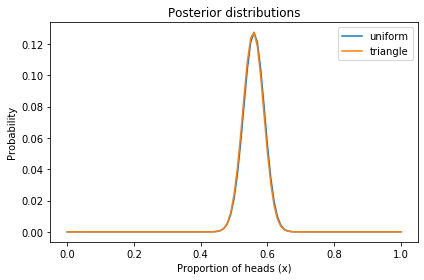

In [27]:
uniform.plot()
triangle.plot()
decorate_euro(title='Posterior distributions')
savefig('fig03-04')

## The binomial likelihood function

We can make the Euro class more efficient by computing the likelihood of the entire dataset at once, rather than one coin toss at a time.

If the probability of heads is `p`, we can compute the probability of `k=140` heads in `n=250` tosses using the binomial PMF.

In [28]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update the PMF using the binomial distribution.
    
    pmf: Pmf representing the prior
    data: tuple of integers k and n
    """
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [29]:
uniform2 = Pmf(1, hypos, name='uniform2')
data = 140, 250
update_binomial(uniform2, data)

Here's what the posterior looks like.

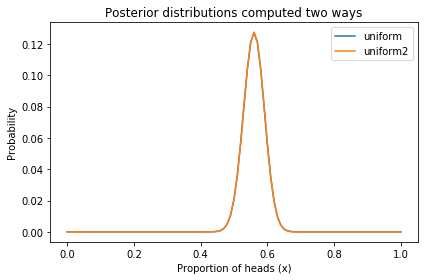

In [30]:
uniform.plot()
uniform2.plot()
decorate_euro(title='Posterior distributions computed two ways')

The results are the same, within floating-point error.

In [31]:
np.max(np.abs(uniform-uniform2))

1.4849232954361469e-15

## Exercises


**Exercise:** In Major League Baseball, most players have a batting average between 200 and 330, which means that the probability of getting a hit is between 0.2 and 0.33.

Suppose a new player appearing in his first game gets 3 hits out of 3 attempts.  What is the posterior distribution for his probability of getting a hit?

For this exercise, I will construct the prior distribution by starting with a uniform distribution and updating it with imaginary data until it has a shape that reflects my background knowledge of batting averages.

In [35]:
hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)

In [36]:
likelihood = {
    'Y': hypos,
    'N': 1-hypos
}

In [37]:
dataset = 'Y' * 25 + 'N' * 75

In [38]:
for data in dataset:
    prior *= likelihood[data]

prior.normalize()

1.3596964206970507e-23

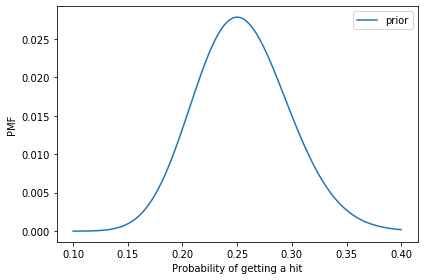

In [39]:
prior.plot(label='prior')
decorate(xlabel='Probability of getting a hit',
         ylabel='PMF')

This distribution indicates that most players have a batting average near 250, with only a few players below 175 or above 350.  I'm not sure how accurately this prior reflects the distribution of batting averages in Major League Baseball, but it is good enough for this exercise.

Now update this distribution with the data and plot the posterior.  What is the most likely value in the posterior distribution?

In [40]:
# Solution

posterior = prior.copy()

for data in 'YYY':
    posterior *= likelihood[data]

posterior.normalize()

0.017944179687707326

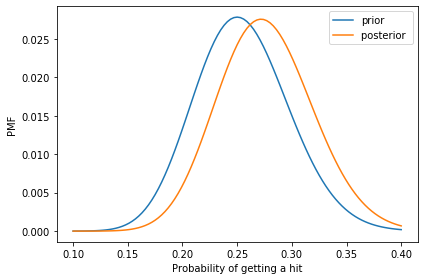

In [41]:
# Solution

prior.plot(label='prior')
posterior.plot(label='posterior ')
decorate(xlabel='Probability of getting a hit',
         ylabel='PMF')

In [42]:
# Solution

prior.max_prob()

0.25

In [43]:
# Solution

posterior.max_prob()

0.271

**Exercise:** Whenever you survey people about sensitive issues, you have to deal with [social desirability bias](https://en.wikipedia.org/wiki/Social_desirability_bias), which is the tendency of people to shade their answers to show themselves in the most positive light.

One of the ways to improve the accuracy of the results is [randomized response](https://en.wikipedia.org/wiki/Randomized_response).

As an example, suppose you ask 100 people to flip a coin and:

* If they get heads, they report YES.

* If they get tails, they honestly answer the question "Do you cheat on your taxes?"

And suppose you get 80 YESes and 20 NOs.  Based on this data, what is the posterior distribution for the fraction of people who cheat on their taxes?  What is the most likely value in the posterior distribution?

In [44]:
# Solution

hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

In [45]:
# Solution

likelihood = {
    'Y': 0.5 + hypos/2,
    'N': (1-hypos)/2
}

In [46]:
# Solution

dataset = 'Y' * 80 + 'N' * 20

posterior = prior.copy()

for data in dataset:
    posterior *= likelihood[data]

posterior.normalize()

3.6945139133967024e-21

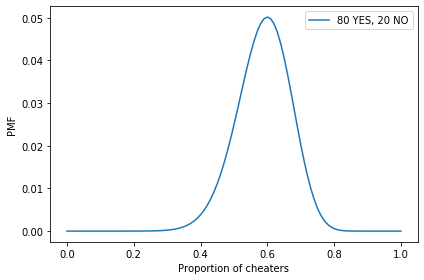

In [47]:
# Solution

posterior.plot(label='80 YES, 20 NO')
decorate(xlabel='Proportion of cheaters',
         ylabel='PMF')

In [48]:
# Solution

posterior.idxmax()

0.6

**Exercise:** Suppose that instead of observing coin spins directly, you measure the outcome using an instrument that is not always correct.  Specifically, suppose the probability is `y=0.2` that an actual heads is reported
as tails, or actual tails reported as heads.

If we spin a coin 250 times and the instrument reports 140 heads, what is the posterior distribution of `x`?

What happens as you vary the value of `y`?

In [49]:
# Solution

def update_unreliable(pmf, dataset, y):
    
    likelihood = {
        'H': (1-y) * hypos + y * (1-hypos),
        'T': y * hypos + (1-y) * (1-hypos)
    }
    for data in dataset:
        pmf *= likelihood[data]

    pmf.normalize()

In [50]:
# Solution

hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)
dataset = 'H' * 140 + 'T' * 110

posterior00 = prior.copy()
update_unreliable(posterior00, dataset, 0.0)

posterior02 = prior.copy()
update_unreliable(posterior02, dataset, 0.2)

posterior04 = prior.copy()
update_unreliable(posterior04, dataset, 0.4)

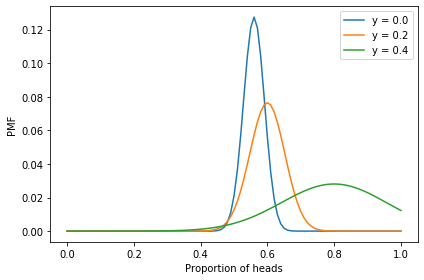

In [51]:
# Solution

posterior00.plot(label='y = 0.0')
posterior02.plot(label='y = 0.2')
posterior04.plot(label='y = 0.4')
decorate(xlabel='Proportion of heads',
         ylabel='PMF')

In [52]:
# Solution

posterior.idxmax()

0.6

**Exercise:** In preparation for an alien invasion, the Earth Defense League (EDL) has been working on new missiles to shoot down space invaders.  Of course, some missile designs are better than others; let's assume that each design has some probability of hitting an alien ship, `x`.

Based on previous tests, the distribution of `x` in the population of designs is approximately uniform between 0.1 and 0.4.

Now suppose the new ultra-secret Alien Blaster 9000 is being tested.  In a press conference, an EDL general reports that the new design has been tested twice, taking two shots during each test.  The results of the test are confidential, so the general won't say how many targets were hit, but they report: "The same number of targets were hit in the two tests, so we have reason to think this new design is consistent."

Is this data good or bad; that is, does it increase or decrease your estimate of `x` for the Alien Blaster 9000?

Hint: If the probability of hitting each target is $x$, the probability of hitting one target in both tests is $[2x(1-x)]^2$.

In [53]:
# Solution

hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)

In [54]:
# Solution

# specific version for n=2 shots
x = hypos
likes = [(1-x)**4, (2*x*(1-x))**2, x**4]
likelihood = np.sum(likes, axis=0)

In [55]:
# Solution

# general version for any n shots per test

from scipy.stats import binom

n = 2
likes2 = [binom.pmf(k, n, x)**2 for k in range(n+1)]
likelihood2 = np.sum(likes2, axis=0)

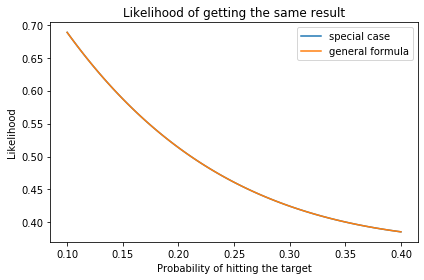

In [56]:
# Solution

plt.plot(x, likelihood, label='special case')
plt.plot(x, likelihood2, label='general formula')
decorate(xlabel='Probability of hitting the target',
         ylabel='Likelihood',
         title='Likelihood of getting the same result')

In [57]:
# Solution

posterior = prior * likelihood
posterior.normalize()

49.129627998379995

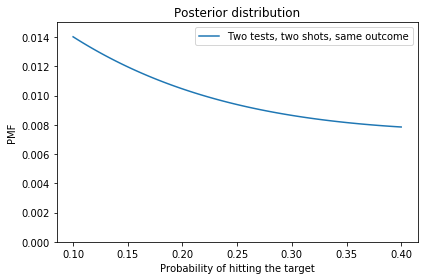

In [58]:
# Solution

posterior.plot(label='Two tests, two shots, same outcome')
decorate(xlabel='Probability of hitting the target',
         ylabel='PMF',
         title='Posterior distribution',
         ylim=[0, 0.015])

In [59]:
# Getting the same result in both tests is more likely for 
# extreme values of `x` and least likely when `x=0.5`.

# In this example, the prior suggests that `x` is less than 0.5,
# and the update gives more weight to extreme values.

# So the data makes lower values of `x` more likely.